# 寻找捐赠者项目

在这个项目中，你将使用1994年美国人口普查收集的数据，选用几个监督学习算法以准确地建模被调查者的收入。然后，你将根据初步结果从中选择出最佳的候选算法，并进一步优化该算法以最好地建模这些数据。你的目标是建立一个能够准确地预测被调查者年收入是否超过50000美元的模型。这种类型的任务会出现在那些依赖于捐款而存在的非营利性组织。了解人群的收入情况可以帮助一个非营利性的机构更好地了解他们要多大的捐赠，或是否他们应该接触这些人。虽然我们很难直接从公开的资源中推断出一个人的一般收入阶层，但是我们可以（也正是我们将要做的）从其他的一些公开的可获得的资源中获得一些特征从而推断出该值。

这个项目的数据集来自[UCI机器学习知识库](https://archive.ics.uci.edu/ml/datasets/Census+Income)。这个数据集是由Ron Kohavi和Barry Becker在发表文章_"Scaling Up the Accuracy of Naive-Bayes Classifiers: A Decision-Tree Hybrid"_之后捐赠的，你可以在Ron Kohavi提供的[在线版本](https://www.aaai.org/Papers/KDD/1996/KDD96-033.pdf)中找到这个文章。我们在这里探索的数据集相比于原有的数据集有一些小小的改变，比如说移除了特征`'fnlwgt'` 以及一些遗失的或者是格式不正确的记录。

----
## 探索数据
载入人口信息数据集。注数据集的最后一列`'income'`将是我们需要预测的列（表示被调查者的年收入会大于或者是最多50,000美元），人口普查数据中的每一列都将是关于被调查者的特征。

In [1]:
# 为这个项目导入需要的库
import numpy as np
import pandas as pd
from time import time
from IPython.display import display # 允许为DataFrame使用display()

# 导入附加的可视化代码visuals.py
import visuals as vs
import warnings
warnings.filterwarnings('ignore')
# 为notebook提供更加漂亮的可视化
%matplotlib inline

# 导入人口普查数据
data = pd.read_csv("census.csv")

# 成功 - 显示第一条记录
display(data.head(n=1))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K


### 数据探索
首先我们对数据集进行一个粗略的探索，我们将看看每一个类别里会有多少被调查者？并且告诉我们这些里面多大比例是年收入大于50,000美元的。

In [2]:
# 总的记录数
n_records = data.shape[0]

# 被调查者的收入大于$50,000的人数
n_greater_50k = data[data.income == '>50K'].shape[0]

# 被调查者的收入最多为$50,000的人数
n_at_most_50k = data[data.income == '<=50K'].shape[0]

# 被调查者收入大于$50,000所占的比例
greater_percent = 100*float(n_greater_50k)/float(n_records)

# 打印结果
print ("总的记录数: {}".format(n_records))
print ("被调查者的收入大于$50,000的人数: {}".format(n_greater_50k))
print ("被调查者的收入最多为$50,000的人数: {}".format(n_at_most_50k))
print ("被调查者收入大于$50,000所占的比例: {:.2f}%".format(greater_percent))

总的记录数: 45222
被调查者的收入大于$50,000的人数: 11208
被调查者的收入最多为$50,000的人数: 34014
被调查者收入大于$50,000所占的比例: 24.78%


----
## 准备数据
在数据能够被作为输入提供给机器学习算法之前，它经常需要被清洗，格式化，和重新组织 - 这通常被叫做**预处理**。幸运的是，对于这个数据集，没有我们必须处理的无效或丢失的条目，然而，由于某一些特征存在的特性我们必须进行一定的调整。这个预处理都可以极大地帮助我们提升几乎所有的学习算法的结果和预测能力。

### 获得特征和标签
`income` 列是我们需要的标签，记录一个人的年收入是否高于50K。 因此我们应该把他从数据中剥离出来，单独存放。

In [3]:
# 将数据切分成特征和对应的标签
income_raw = data['income']
features_raw = data.drop('income', axis = 1)

### 转换倾斜的连续特征

一个数据集有时可能包含至少一个靠近某个数字的特征，但有时也会有一些相对来说存在极大值或者极小值的不平衡分布的的特征。算法对这种分布的数据会十分敏感，并且如果这种数据没有能够很好地规一化处理会使得算法表现不佳。在人口普查数据集的两个特征符合这个描述：'`capital-gain'`和`'capital-loss'`。这两个特征属性的数据分布的就非常不均匀，我们将这两个属性数据的分布绘制出来看下


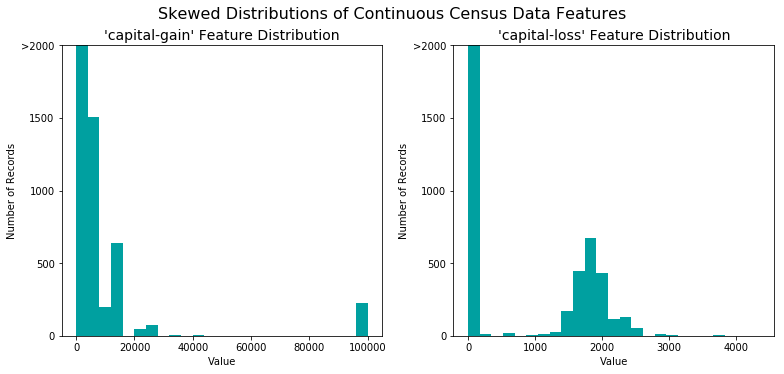

In [4]:
# 可视化 'capital-gain'和'capital-loss' 两个特征
vs.distribution(features_raw)

对于高度倾斜分布的特征如`'capital-gain'`和`'capital-loss'`，常见的做法是对数据施加一个<a href="https://en.wikipedia.org/wiki/Data_transformation_(statistics)">对数转换</a>，将数据转换成对数，这样非常大和非常小的值不会对学习算法产生负面的影响。并且使用对数变换显著降低了由于异常值所造成的数据范围异常。但是在应用这个变换时必须小心：因为0的对数是没有定义的，所以我们必须先将数据处理成一个比0稍微大一点的数以成功完成对数转换。

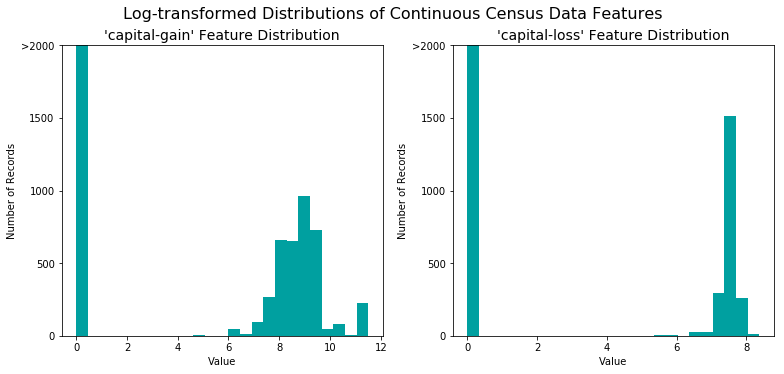

In [5]:
# 对于倾斜的数据使用Log转换
skewed = ['capital-gain', 'capital-loss']
features_raw[skewed] = data[skewed].apply(lambda x: np.log(x + 1))

# 可视化对数转换后 'capital-gain'和'capital-loss' 两个特征
vs.distribution(features_raw, transformed = True)

### 规一化数字特征
除了对于高度倾斜的特征施加转换，对数值特征施加一些形式的缩放通常会是一个好的习惯。在数据上面施加一个缩放并不会改变数据分布的形式（比如上面说的'capital-gain' or 'capital-loss'）；但是，规一化保证了每一个特征在使用监督学习器的时候能够被平等的对待。注意一旦使用了缩放，观察数据的原始形式不再具有它本来的意义了。我们将使用[`sklearn.preprocessing.MinMaxScaler`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html)来完成这个任务。

In [6]:
from sklearn.preprocessing import MinMaxScaler

# 初始化一个 scaler，并将它施加到特征上
scaler = MinMaxScaler()
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
features_raw[numerical] = scaler.fit_transform(data[numerical])

# 显示一个经过缩放的样例记录
display(features_raw.head(n = 1))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.30137,State-gov,Bachelors,0.8,Never-married,Adm-clerical,Not-in-family,White,Male,0.02174,0.0,0.397959,United-States


### 数据预处理

从上面的**数据探索**中的表中，我们可以看到有几个属性的每一条记录都是非数字的。通常情况下，学习算法期望输入是数字的，这要求非数字的特征（称为类别变量）被转换。转换类别变量的一种流行的方法是使用**独热编码**方案。独热编码为每一个非数字特征的每一个可能的类别创建一个_“虚拟”_变量。例如，假设`someFeature`有三个可能的取值`A`，`B`或者`C`，。我们将把这个特征编码成`someFeature_A`, `someFeature_B`和`someFeature_C`.

| 特征X |                    | 特征X_A | 特征X_B | 特征X_C |
| :-: |                            | :-: | :-: | :-: |
|  B  |  | 0 | 1 | 0 |
|  C  | ----> 独热编码 ----> | 0 | 0 | 1 |
|  A  |  | 1 | 0 | 0 |

此外，对于非数字的特征，我们需要将非数字的标签`'income'`转换成数值以保证学习算法能够正常工作。因为这个标签只有两种可能的类别（"<=50K"和">50K"），我们不必要使用独热编码，可以直接将他们编码分别成两个类`0`和`1`，在下面的代码单元中你将实现以下功能：
 - 使用[`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies)对`'features_raw'`数据来施加一个独热编码。
 - 将目标标签`'income_raw'`转换成数字项。
   - 将"<=50K"转换成`0`；将">50K"转换成`1`。

In [7]:
# 使用pandas.get_dummies()对'features_raw'数据进行独热编码
features = pd.get_dummies(features_raw)

# TODO：将'income_raw'编码成数字值
income = income_raw.map({'<=50K':0, '>50K':1})

# 打印经过独热编码之后的特征数量
encoded = list(features.columns)

### 混洗和切分数据
现在所有的 _类别变量_ 已被转换成数值特征，而且所有的数值特征已被规一化。和我们一般情况下做的一样，我们现在将数据（包括特征和它们的标签）切分成训练和测试集。其中80%的数据将用于训练和20%的数据用于测试。然后再进一步把训练数据分为训练集和验证集，用来选择和优化模型。

In [8]:
# 导入 train_test_split
from sklearn.model_selection import train_test_split

# 将'features'和'income'数据切分成训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(features, income, test_size = 0.2, random_state = 0,
                                                    stratify = income)
# 将'X_train'和'y_train'进一步切分为训练集和验证集
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0,
                                                    stratify = y_train)

----
## 评价模型性能
在这一部分中，我们将尝试四种不同的算法，并确定哪一个能够最好地建模数据。四种算法包含一个*天真的预测器* 和三个你选择的监督学习器。

### 评价方法和朴素的预测器
根据项目得需求，我们知道年收入大于\$50,000的人是最有可能捐款的，基于此目的，所以准确判断年收入是否大于\$50,000尤其重要，这突出了查准率，但是还要考虑另一情况，就是对那些实际年收入没有超过\$50,000，我们的模型却判断出是收入超过\$50,000了，认为他有捐款倾向，这样显然是不好的，所以我们又不得不考虑查全率，因此我们使用**F-beta score**作为评价指标，这样能够同时考虑查准率和查全率:

$$ F_{\beta} = (1 + \beta^2) \cdot \frac{precision \cdot recall}{\left( \beta^2 \cdot precision \right) + recall} $$


尤其是，当 $\beta = 0.5$ 的时候更多的强调查准率，这叫做**F$_{0.5}$ score** （或者为了简单叫做F-score）。

###  天真的预测器的性能

通过查看收入超过和不超过 \$50,000 的人数，我们能发现多数被调查者年收入没有超过 \$50,000。如果我们简单地预测说*“这个人的收入没有超过 \$50,000”*，我们就可以得到一个 准确率超过 50% 的预测。这样我们甚至不用看数据就能做到一个准确率超过 50%。这样一个预测被称作是天真的。通常对数据使用一个*天真的预测器*是十分重要的，这样能够帮助建立一个模型表现是否好的基准。 使用下面的代码单元计算天真的预测器的相关性能。将你的计算结果赋值给`'accuracy'`, `‘precision’`, `‘recall’` 和 `'fscore'`，这些值会在后面被使用

*如果我们选择一个无论什么情况都预测被调查者年收入大于 \$50,000 的模型，那么这个模型在**验证集上**的准确率，查准率，查全率和 F-score是多少？*  

In [9]:
#不能使用scikit-learn，你需要根据公式自己实现相关计算。

#计算准确率
accuracy = y_val.value_counts()[1] / len(y_val)

# 计算查准率 Precision
precision = y_val.value_counts()[1] / len(y_val)

# 计算查全率 Recall
recall = 1

# 设置beta=0.5，计算F-score
fscore = ((1 + 0.5**2) * precision * recall) / ((0.5**2 * precision) + recall)

# 打印结果
print ("天真的预测器在验证集的: \n \
    准确率: {:.4f} \n \
    查准率: {:.4f} \n \
    查全率: {:.4f} \n \
    F-score: {:.4f}".format(accuracy, precision, recall, fscore))

天真的预测器在验证集的: 
     准确率: 0.2478 
     查准率: 0.2478 
     查全率: 1.0000 
     F-score: 0.2917


## 监督学习模型
### 选择适合的模型

你能够在 [`scikit-learn`](http://scikit-learn.org/stable/supervised_learning.html) 中选择以下监督学习模型
- 高斯朴素贝叶斯 (GaussianNB)
- 决策树 (DecisionTree)
- 集成方法 (Bagging, AdaBoost, Random Forest, Gradient Boosting)
- K近邻 (K Nearest Neighbors)
- 随机梯度下降分类器 (SGDC)
- 支撑向量机 (SVM)
- Logistic回归（LogisticRegression）

从上面的监督学习模型中选择三个适合项目的模型，解释分析为什么做出这个选择。

### 模型1

**模型名称**

回答：决策树


**描述一个该模型在真实世界的一个应用场景。（你需要为此做点研究，并给出你的引用出处）**

回答：可以使用决策所对个人房屋贷款做信用评估，看是否具备贷款能力，我们可以根据个人的职业，收入，个人资产，家庭成员的经济情况等各种特征
     进行分析，我们构建决策树对每一个特征进行判断，得到的叶子节点表示用户是否具有贷款资格。这类应用很多论文都有提及。可以在百度学术中找到，或者去知网搜寻相关文章。

**这个模型的优势是什么？他什么情况下表现最好？**

回答： 1:速度快，计算量相对较小。
      2:分类精度高，挖掘出来的分类规则准确性高, 容易理解, 决策树可以清晰的显示哪些属性比较重要, 即可以生成可以理解的规则.
      3:使用统计验证模型，模型可靠性高
      4:对异常值不敏感
      5:能够同时处理数据型和常规型属性。其他的技术往往要求数据属性的单一。

**这个模型的缺点是什么？什么条件下它表现很差？**

回答：
     1：容易导致过拟合
     2：会忽略特征之间的相互关系
     3：如果数据在不同种类上的数据量不同，决策时可能会偏向数据量更大的一方

**根据我们当前数据集的特点，为什么这个模型适合这个问题。**

回答：我们的问题是分析个人收入是否大于50000美金，属于一个二分类问题，适用于决策树

### 模型2

**模型名称**

回答：SVM


**描述一个该模型在真实世界的一个应用场景。（你需要为此做点研究，并给出你的引用出处）**

回答：SVM可以应用于文本分类问题，通过分词，特征提取，将数据整理好，交给svm训练。
     也可以做比如人脸识别，语音识别，文字识别等。
     https://wenku.baidu.com/view/ad8e3461bb4cf7ec4bfed066.html

**这个模型的优势是什么？他什么情况下表现最好？**

回答：1:小数据量下表现良好
      2:在非线性可分问题上表现优秀
      3：SVM计算复杂性不取决于样本空间的维数,而取决于支持向量的数目。一定程度上避免了维数灾难
      4:噪声较小，小样本的情况下表现良好
**这个模型的缺点是什么？什么条件下它表现很差？**

回答：1:不适合大规模训练样本
      2:难以解决多分类问题,svm比较适合二分类问题

**根据我们当前数据集的特点，为什么这个模型适合这个问题。**

回答：1:我们的数据量不大
      2:我们的预测是个二分类问题，符合svm

### 模型3

**模型名称**

回答：集成方法(采用AdaBoost)


**描述一个该模型在真实世界的一个应用场景。（你需要为此做点研究，并给出你的引用出处）**

回答：马疝病的预测的应用,预测患有疝气病的马的存活问题
     https://www.cnblogs.com/jiangzhonglian/p/7698312.html
     AdaBoost可以应用与模式识别、计算机视觉领域，用于二分类和多分类场景

**这个模型的优势是什么？他什么情况下表现最好？**

回答：1.可以使用各种方法构建子分类器，讲其他弱分类器组合，生成一个强分类器，
      2.adaboost是一种有很高精度的分类器
      3.当使用简单分类器时，计算出的结果是可以理解的，而且弱分类器构造极其简单
      4.简单，不用做特征筛选
      5.不容易发生过拟合

**这个模型的缺点是什么？什么条件下它表现很差？**

回答：1.对离散数据点敏感
      2.adaBoost对弱分类器的数目的不好设定
      3.数据分布不均匀导致分类精度下降
      4.训练比较耗时

**根据我们当前数据集的特点，为什么这个模型适合这个问题。**

回答：集成方法可以将不同的分类算法作为弱分类器，组合起来，构造一个分类器，可以有效提升模型的性能，并且适合二分类问题。

### 创建模型并进行预测

 - 从[`sklearn.metrics`](http://scikit-learn.org/stable/modules/classes.html#sklearn-metrics-metrics)中导入`fbeta_score`和`accuracy_score`。
 - 用训练集拟合学习器，并记录训练时间。
 - 对训练集的前300个数据点和验证集进行预测并记录预测时间。
 - 计算预测训练集的前300个数据点的准确率和F-score。
 - 计算预测验证集的准确率和F-score。

In [10]:
# 从sklearn中导入两个评价指标 - fbeta_score和accuracy_score
from sklearn.metrics import fbeta_score, accuracy_score

def train_predict(learner, sample_size, X_train, y_train, X_val, y_val): 
    '''
    输入参数:
       - learner: 用于训练和预测的学习器
       - sample_size: 样本数量
       - X_train: 训练集
       - y_train: 训练集结果标签
       - X_val: 验证集
       - y_val: 验证集结果标签
    '''
    
    results = {}
    
    # 使用sample_size大小的训练数据来拟合学习器
    start = time() # 获得程序开始时间
    learner = learner.fit(X_train[:sample_size], y_train[:sample_size])
    end = time() # 获得程序结束时间
    
    # 计算训练时间
    results['train_time'] = end - start
    
    # 得到在验证集上的预测值
    #       然后得到对前300个训练数据的预测结果
    start = time() # 获得程序开始时间
    predictions_val = learner.predict(X_val)
    predictions_train = learner.predict(X_train[:300])
    end = time() # 获得程序结束时间
    
    # 计算预测用时
    results['pred_time'] = end - start
            
    # 计算在最前面的300个训练数据的准确率
    results['acc_train'] = accuracy_score(y_train[:300], predictions_train)
        
    # 计算在验证上的准确率
    results['acc_val'] = accuracy_score(y_val, predictions_val)
    
    # 计算在最前面300个训练数据上的F-score
    results['f_train'] = fbeta_score(y_train[:300], predictions_train, beta = 0.5)
        
    # 计算验证集上的F-score
    results['f_val'] = fbeta_score(y_val, predictions_val, beta = 0.5)
       
    # 成功
    print ("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    # 返回结果
    return results

###  初始模型的评估
             
- 导入你在前面讨论的三个监督学习模型。             
- 初始化三个模型并存储在`'clf_A'`，`'clf_B'`和`'clf_C'`中。
  - 使用模型的默认参数值，在接下来后边的部分中将需要对某一个模型的参数进行调整。             
  - 设置`random_state`  (如果有这个参数)。       
- 计算1%， 10%， 100%的训练数据分别对应多少个数据点，并将这些值存储在`'samples_1'`, `'samples_10'`, `'samples_100'`中

289
2894
28941
DecisionTreeClassifier trained on 289 samples.
DecisionTreeClassifier trained on 2894 samples.
DecisionTreeClassifier trained on 28941 samples.
SVC trained on 289 samples.
SVC trained on 2894 samples.
SVC trained on 28941 samples.
AdaBoostClassifier trained on 289 samples.
AdaBoostClassifier trained on 2894 samples.
AdaBoostClassifier trained on 28941 samples.


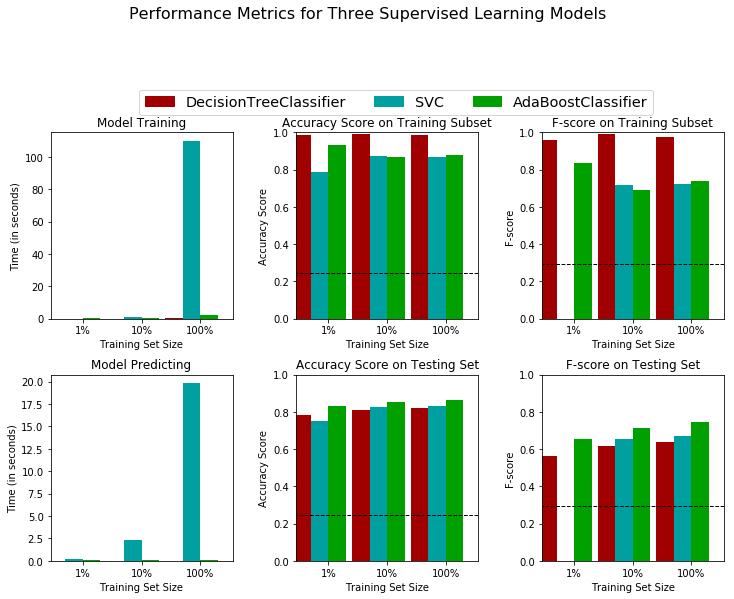

In [11]:
# 从sklearn中导入三个监督学习模型

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
# 初始化三个模型
clf_A = DecisionTreeClassifier(random_state=4)
clf_B = SVC(random_state=4)
clf_C = AdaBoostClassifier(random_state=4)

# 计算1%， 10%， 100%的训练数据分别对应多少点
samples_1 = (int)(X_train.shape[0]  / 100)
samples_10 = (int)(X_train.shape[0]  / 10)
samples_100 = X_train.shape[0]
print(samples_1)
print(samples_10)
print(samples_100)
# 收集学习器的结果
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = train_predict(clf, samples, X_train, y_train, X_val, y_val)

# 对选择的三个模型得到的评价结果进行可视化
vs.evaluate(results, accuracy, fscore)

###  选择最佳的模型

*基于上边对模型的评估，绘制出的条形图，看看哪个是最适合的模型*             

**回答：**
* 综合来看选择集成算法AdaBoost，首先在运行时间上，svm明显比其它算法慢很多，在训练集和测试集的Accuracy Score和F-Score也要比其余两个模型低，故首先排除掉svm，然后再比对决策树和AdaBoost，在训练集上决策树在Accuracy Score和F-Score两个方面都要比AdaBoost要占据优势，但是在测试集上，AdaBoost的评分比决策树要高，决策树在训练集上和测试集上，分数有一定的差距，有过拟合的趋势，而AdaBoost在训练集和测试集上表现都比较稳定，也能看出AdaBoost有不容易发生过拟合的优点。所以，综上选择AdaBoost算法

### 模型调优
调节选择的模型的参数。使用网格搜索（GridSearchCV）来调整模型的重要参数

In [12]:
# 导入'GridSearchCV', 'make_scorer'和其他一些需要的库
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
# 初始化分类器
clf = AdaBoostClassifier(random_state=4)

# 创建你希望调节的参数列表
parameters = {'n_estimators':[10,50,100,150],'learning_rate':[1,1.5,2],
              'algorithm':['SAMME.R','SAMME'],
              'base_estimator':[DecisionTreeClassifier(max_depth=1),DecisionTreeClassifier(max_depth=2),
                                DecisionTreeClassifier(max_depth=4)]}

# 创建一个fbeta_score打分对象
scorer = make_scorer(fbeta_score, beta=0.5)

# 在分类器上使用网格搜索，使用'scorer'作为评价函数
grid_obj = GridSearchCV(clf, parameters,scorer)

# 用训练数据拟合网格搜索对象并找到最佳参数
grid_obj.fit(X_train, y_train)
# 得到estimator
best_clf = grid_obj.best_estimator_

# 使用没有调优的模型做预测
predictions = (clf.fit(X_train, y_train)).predict(X_val)
best_predictions = best_clf.predict(X_val)

# 汇报调优后的模型
print ("best_model\n------")
print (best_clf)

# 汇报调参前和调参后的分数
print ("\nUnoptimized model\n------")
print ("Accuracy score on validation data: {:.4f}".format(accuracy_score(y_val, predictions)))
print ("F-score on validation data: {:.4f}".format(fbeta_score(y_val, predictions, beta = 0.5)))
print ("\nOptimized Model\n------")
print ("Final accuracy score on the validation data: {:.4f}".format(accuracy_score(y_val, best_predictions)))
print ("Final F-score on the validation data: {:.4f}".format(fbeta_score(y_val, best_predictions, beta = 0.5)))

best_model
------
AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=1, n_estimators=50, random_state=4)

Unoptimized model
------
Accuracy score on validation data: 0.8648
F-score on validation data: 0.7443

Optimized Model
------
Final accuracy score on the validation data: 0.8737
Final F-score on the validation data: 0.7613


----
## 特征的重要性

在数据上（比如我们这里使用的人口普查的数据）使用监督学习算法的一个重要的任务是决定哪些特征能够提供最强的预测能力。专注于少量的有效特征和标签之间的关系，我们能够更加简单地理解这些现象，这在很多情况下都是十分有用的。在这个项目的情境下这表示我们希望选择一小部分特征，这些特征能够在预测被调查者是否年收入大于\$50,000这个问题上有很强的预测能力。

选择一个有 `'feature_importance_'` 属性的scikit学习分类器（例如 AdaBoost，随机森林）。`'feature_importance_'` 属性是对特征的重要性排序的函数。在下一个代码单元中用这个分类器拟合训练集数据并使用这个属性来决定人口普查数据中最重要的5个特征。